In [1]:
import math
import importlib
from typing import Literal

import torch
from torch import Tensor
import pandas as pd
import seaborn as sns

from ax import Client, RangeParameterConfig

from botorch.models import SingleTaskGP
from botorch.acquisition import qLogExpectedImprovement, qMaxValueEntropy

from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior

from src.toy_functions import ResponseFunction, six_curve_sum
from src.model_generation import get_full_strategy
from src import GPVisualiser, ax_helper
from src.ax_helper import get_guess_coords


<Axes: >

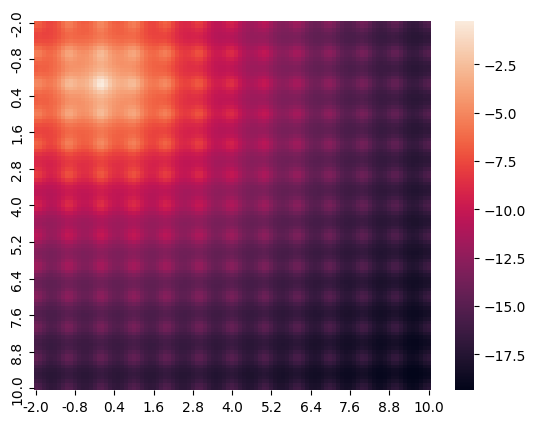

In [2]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    ),
    RangeParameterConfig(
        name="x2", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1", "x2"]


def test_function(x1, x2):
    # Ackley function (commonly used for optimization benchmarks)
    a = 20
    b = 0.2
    c = 2 * math.pi
    sum_sq = 0.5 * (x1**2 + x2**2)
    cos_comp = 0.5 * (math.cos(c * x1) + math.cos(c * x2))
    ackley_grid = -a * math.exp(-b * math.sqrt(sum_sq)) - math.exp(cos_comp) + a + math.exp(1)
    return -ackley_grid


import numpy as np
grid = np.linspace(-2, 10, 101)
x1_grid, x2_grid = np.meshgrid(grid, grid)
ackley_vals = np.array([test_function(x1, x2) for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())]).reshape(x1_grid.shape)
sns.heatmap(
    pd.DataFrame(ackley_vals, index=np.round(grid, 2), columns=np.round(grid, 2)),
    xticklabels=10,
    yticklabels=10
)

# Sobol
The default initial parameter exploration strategy uses SOBOL algorithm:

### log param sobol:

[INFO 09-22 11:57:21] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-22 11:57:21] ax.api.client: Generated new trial 0 with parameters {'x0': 10.0, 'x1': 10.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-22 11:57:21] ax.api.client: Generated new trial 1 with parameters {'x0': 2.474364, 'x1': 1.365594} using GenerationNode Sobol.
[INFO 09-22 11:57:21] ax.api.client: Generated new trial 2 with parameters {'x0': 13.624741, 'x1': 30.126061} using GenerationNode Sobol.
[INFO 09-22 11:57:21] ax.api.client: Generated new tri

   trial_name         x0         x1
0         0_0  10.000000  10.000000
1         1_0   2.474364   1.365594
2         2_0  13.624741  30.126061
3         3_0  62.468981   3.869805
4         4_0   3.567781  63.953943
5         5_0   9.201312   5.862749
6         6_0  48.874225  40.905639
7         7_0  22.408348   2.749694
8         8_0   1.326658  14.368173
9         9_0   1.749191   5.025986
10       10_0  29.680391  83.338810
11       11_0  36.889100   1.068193
12       12_0   6.976692  23.589092
13       13_0   4.705235   2.158053
14       14_0  82.762363  11.314283
15       15_0  10.286837   7.588991
16       16_0   1.876734  53.003728
17       17_0   2.353760   9.097663
18       18_0  12.628693  47.513634
19       19_0  86.698041   1.805145
20       20_0   5.184712  12.587359
21       21_0   6.331396   1.191474
22       22_0  35.214899  19.680404
23       23_0  24.176214   4.518377
24       24_0   1.394712  99.619369
25       25_0   1.052907   2.466138
26       26_0  18.332213  17

<Axes: xlabel='x0', ylabel='x1'>

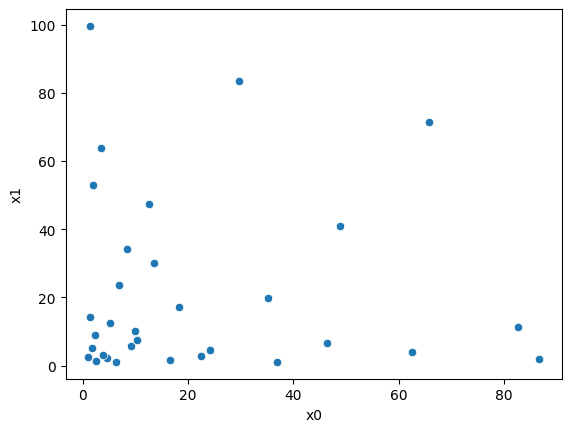

In [3]:
client = Client()

client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
            scaling = 'log',
        ) for i in range(len(dim_names))
    ],
)


client.configure_optimization(objective="-loss")

client.get_next_trials(max_trials=32)

coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

Low value oversampling is inline with logarithmic distribution.

**Considering that we expect overexpression to be optimal when compared to underexpression, Sobol should be run on a linear scale**.

### linear parameters sobol

[INFO 09-22 11:57:21] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-22 11:57:21] ax.api.client: Generated new trial 0 with parameters {'x1': 50.5, 'x2': 50.5} using GenerationNode CenterOfSearchSpace.
[INFO 09-22 11:57:21] ax.api.client: Generated new trial 1 with parameters {'x1': 57.187521, 'x2': 26.317562} using GenerationNode Sobol.
[INFO 09-22 11:57:21] ax.api.client: Generated new trial 2 with parameters {'x1': 27.798707, 'x2': 95.873689} using GenerationNode Sobol.
[INFO 09-22 11:57:21] ax.api.client: Generated new t

<Axes: xlabel='x1', ylabel='x2'>

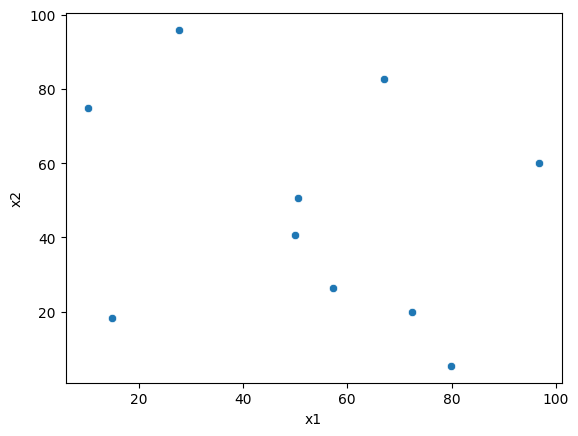

In [4]:
client = Client()

parameters=[
    RangeParameterConfig(
        name=dim,
        bounds=(1, 100),
        parameter_type="float",
        # scaling = 'log',
    ) for dim in dim_names
]


client.configure_experiment(
    name="batch_bo_test",
    parameters=parameters
)

client.configure_optimization(objective="response")
client.get_next_trials(max_trials=10)

coords = get_guess_coords(client)

sns.scatterplot(data=coords, x="x1", y="x2")

A nice and informative initial guess grid is formed

[INFO 09-22 11:57:21] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-22 11:57:21] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0, 'x2': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-22 11:57:21] ax.api.client: Generated new trial 1 with parameters {'x1': 6.814562, 'x2': -1.128778} using GenerationNode Sobol.
[INFO 09-22 11:57:21] ax.api.client: Generated new trial 2 with parameters {'x1': 2.828143, 'x2': 6.121021} using GenerationNode Sobol.
[INFO 09-22 11:57:21] ax.api.client: Generated new trial 

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'GP along x1'}, xlabel='x1', ylabel='response'>,
        <Axes: title={'center': 'GP along x2'}, xlabel='x2', ylabel='response'>],
       dtype=object))

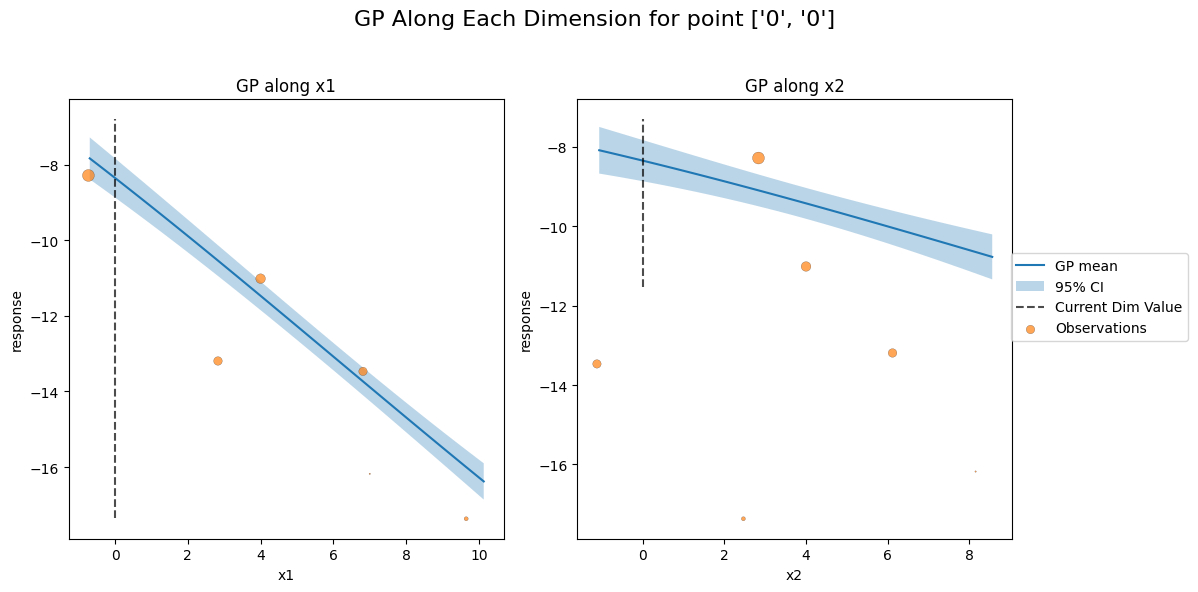

In [5]:
client = Client()

client.configure_experiment(parameters=range_parameters)


client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

obs = ax_helper.get_obs_from_client(client, response_col='response')
plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, obs, dim_names, 'response', parameters)
plotter.plot_all([0,0])

In [6]:
obs

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-11.013421
1,1_0,6.814562,-1.128778,-13.468343
2,2_0,2.828143,6.121021,-13.192534
3,3_0,-0.732614,2.833264,-8.280769
4,4_0,7.000507,8.158235,-16.179970
5,5_0,9.650994,2.463536,-17.369491


# Custom Botorch model

### Define the GP surrogate


MES (max value entropy search) should be the ideal choice for acquisition functions because:
* It can handle noise.
* Samples in a manner to best define the optimum.
    * Consequently, will rarely repeat exactly identical samplings.
* Has a cost/fidelity setting

In [7]:
client = Client()
generation_strategy = get_full_strategy(gp=SingleTaskGP, acqf_class=qLogExpectedImprovement)
client.configure_experiment(parameters=range_parameters)

client.set_generation_strategy(
    generation_strategy=generation_strategy,
)
client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

[INFO 09-22 11:57:21] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0, 'x2': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-22 11:57:21] ax.api.client: Generated new trial 1 with parameters {'x1': 9.957832, 'x2': 3.715616} using GenerationNode Sobol.
[INFO 09-22 11:57:21] ax.api.client: Generated new trial 2 with parameters {'x1': 3.147349, 'x2': 5.506743} using GenerationNode Sobol.
[INFO 09-22 11:57:21] ax.api.client: Generated new trial 3 with parameters {'x1': -0.953171, 'x2': -0.299776} using GenerationNode Sobol.
[INFO 09-22 11:57:21] ax.api.client: Generated new trial 4 with parameters {'x1': 4.211627, 'x2': 9.885613} using GenerationNode Sobol.
[INFO 09-22 11:57:21] ax.api.client: Generated new trial 5 with parameters {'x1': 5.739744, 'x2': -1.490626} using GenerationNode Sobol.
[INFO 09-22 11:57:21] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-22 11:57:21] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-22 11:57:21] ax.api.client: Trial 2 marked

[INFO 09-22 11:57:24] ax.api.client: Generated new trial 6 with parameters {'x1': -0.139353, 'x2': 1.094214} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-22 11:57:24] ax.api.client: Generated new trial 7 with parameters {'x1': -2.0, 'x2': -2.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-22 11:57:24] ax.api.client: Generated new trial 8 with parameters {'x1': -2.0, 'x2': 1.031078} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-22 11:57:24] ax.api.client: Generated new trial 9 with parameters {'x1': 0.523051, 'x2': -0.681834} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-22 11:57:24] ax.api.client: Generated new trial 10 with parameters {'x1': -0.203984, 'x2': -2.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-22 11:57:24] ax.api.client: Generated new trial 11 with parameters {'x1': -2.0, 'x2': -0.322761} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-22 

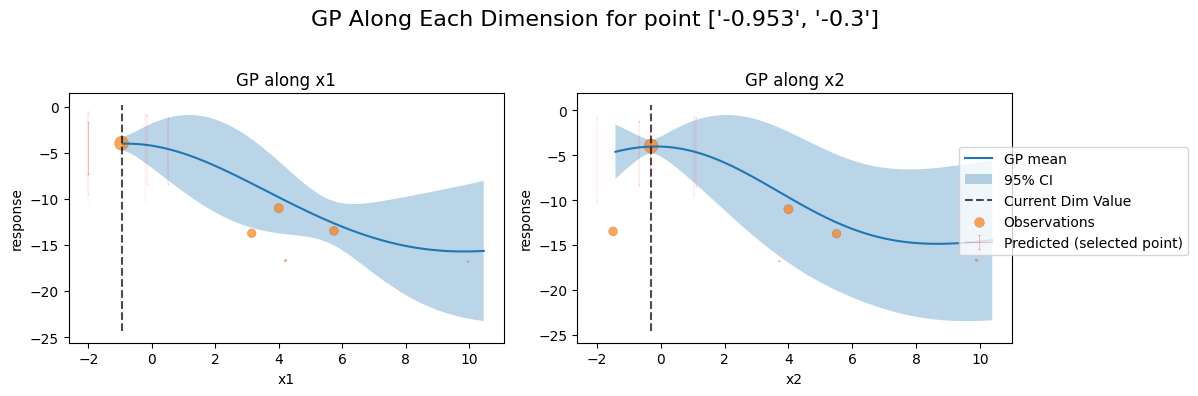

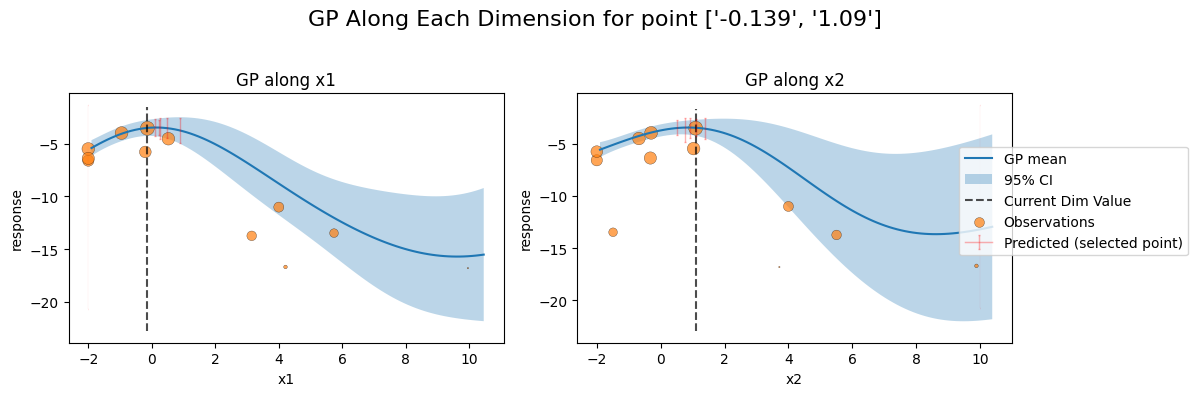

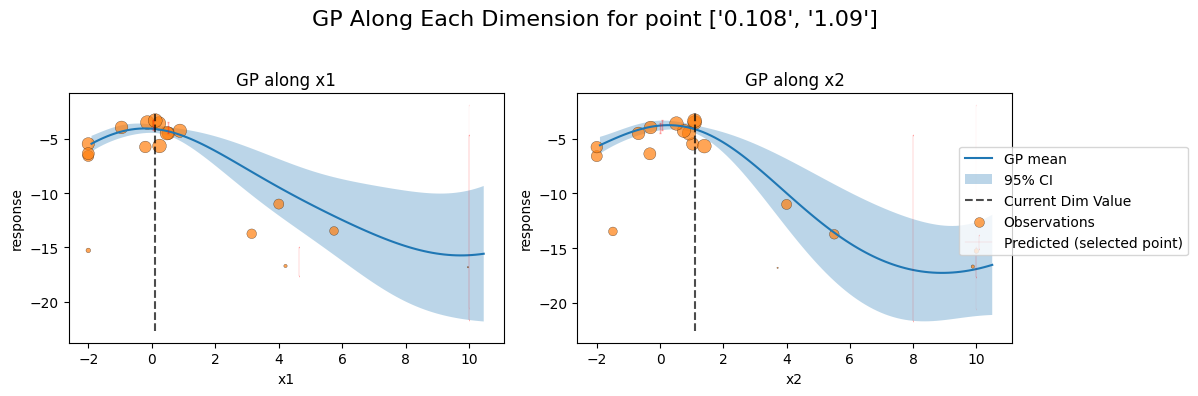

In [8]:
import matplotlib.pyplot as plt
for _ in range(3):
    batch_handler.get_next_batch()

    batch_handler.plot_GP(SingleTaskGP, figsize=(12, 4))
    batch_handler.complete_all_pending()

In [9]:
obs

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-11.013421
1,1_0,6.814562,-1.128778,-13.468343
2,2_0,2.828143,6.121021,-13.192534
3,3_0,-0.732614,2.833264,-8.280769
4,4_0,7.000507,8.158235,-16.179970
5,5_0,9.650994,2.463536,-17.369491


# Technical repeats
Knowing that real biological data posses significant significant noise, the model has to be robust enough to handle technical repeats

In [10]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1"]

test_function = lambda x1: -((x1-2)**2) + 10
noise_fn = lambda x: x + np.random.normal(0, 10)

def plot_test():
    plt.plot(np.linspace(-2, 10, 100), [test_function(x) for x in np.linspace(-2, 10, 100)], color='black', label='True function')

[INFO 09-22 11:57:37] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-22 11:57:37] ax.api.client: Generated new trial 1 with parameters {'x1': 1.94489} using GenerationNode Sobol.
[INFO 09-22 11:57:37] ax.api.client: Generated new trial 2 with parameters {'x1': 9.973002} using GenerationNode Sobol.
[INFO 09-22 11:57:37] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-22 11:57:37] ax.api.client: Trial 3 marked COMPLETED.
[INFO 09-22 11:57:37] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-22 11:57:37] ax.api.client: Trial 4 marked COMPLETED.
[INFO 09-22 11:57:37] ax.api.client: Trial 2 marked COMPLETED.
[INFO 09-22 11:57:37] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-22 11:57:38] ax.api.client: Generated new trial 6 with parameters {'x1': -2.0} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-22 11:57:38] ax.api.client: Generated new trial 7 with parameters {'x1': -0.367483} using Generati

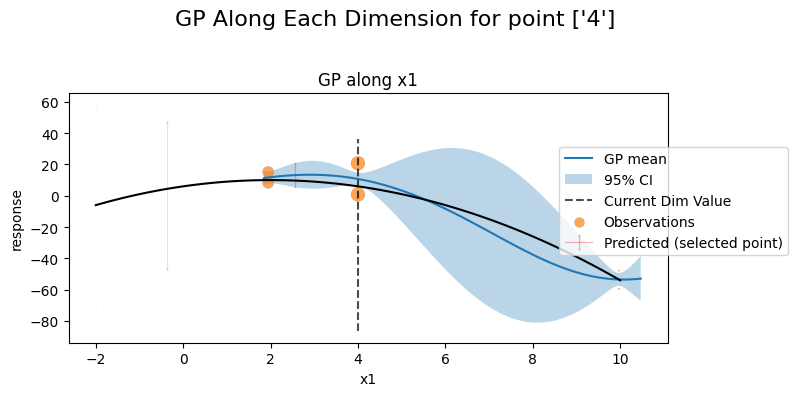

[INFO 09-22 11:57:39] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-22 11:57:39] ax.api.client: Trial 9 marked COMPLETED.
[INFO 09-22 11:57:39] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-22 11:57:39] ax.api.client: Trial 10 marked COMPLETED.
[INFO 09-22 11:57:39] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-22 11:57:39] ax.api.client: Trial 11 marked COMPLETED.
[INFO 09-22 11:57:40] ax.api.client: Generated new trial 12 with parameters {'x1': 1.872634} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-22 11:57:40] ax.api.client: Generated new trial 13 with parameters {'x1': 2.534497} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-22 11:57:40] ax.api.client: Generated new trial 14 with parameters {'x1': 3.492563} using GenerationNode SingleTaskGP+qLogExpectedImprovement.


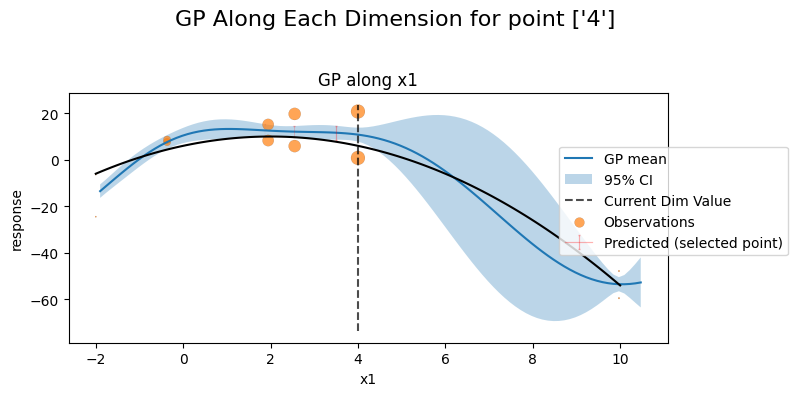

[INFO 09-22 11:57:40] ax.api.client: Trial 12 marked COMPLETED.
[INFO 09-22 11:57:40] ax.api.client: Trial 15 marked COMPLETED.
[INFO 09-22 11:57:40] ax.api.client: Trial 13 marked COMPLETED.
[INFO 09-22 11:57:40] ax.api.client: Trial 16 marked COMPLETED.
[INFO 09-22 11:57:40] ax.api.client: Trial 14 marked COMPLETED.
[INFO 09-22 11:57:40] ax.api.client: Trial 17 marked COMPLETED.
[INFO 09-22 11:57:42] ax.api.client: Generated new trial 18 with parameters {'x1': 5.767229} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-22 11:57:42] ax.api.client: Generated new trial 19 with parameters {'x1': 5.389165} using GenerationNode SingleTaskGP+qLogExpectedImprovement.
[INFO 09-22 11:57:42] ax.api.client: Generated new trial 20 with parameters {'x1': 9.774581} using GenerationNode SingleTaskGP+qLogExpectedImprovement.


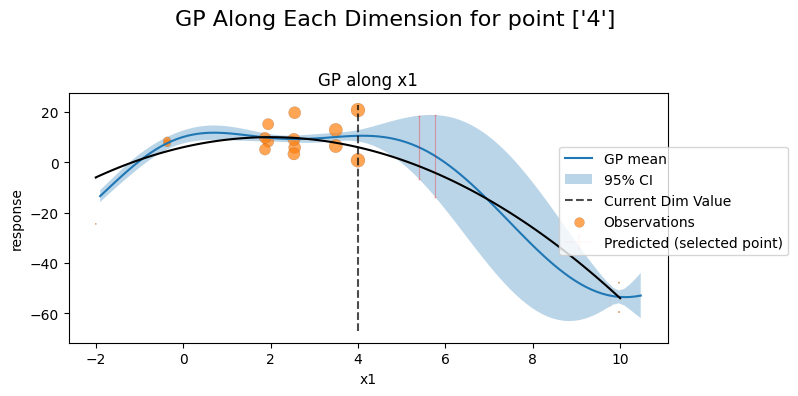

In [ ]:
def sequential_runs(gp, acqf_class=qLogExpectedImprovement, n_runs=10, batch_size=1, technical_repeats=1,  noise_fn=None, plot_each = False):
    """Handles Simulating batch experiments sequentially."""
    client = Client()
    client.configure_experiment(parameters=range_parameters)
    client.configure_optimization(objective=metric_name)

    if noise_fn is None:
        noise_fn = lambda x: x

    generation_strategy = get_full_strategy(gp=gp, acqf_class=acqf_class)

    client.set_generation_strategy(
        generation_strategy=generation_strategy)

    handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=batch_size, range_params=range_parameters)
    handler.get_next_batch(batch_size)

    for _ in range(n_runs):
        handler.comp_noise_and_repeats(noise_fn=noise_fn, repeats=technical_repeats)
        handler.get_next_batch()
        if plot_each:
            handler.plot_GP(gp, figsize=(8, 4))
            plot_test()
            plt.show()
    return handler


runs = sequential_runs(SingleTaskGP, n_runs=3, technical_repeats=2, batch_size=3, noise_fn=noise_fn, plot_each=True)

* This simple Kernel is incapable of encompassing noise. Consequently, it overfits.
* Technical repeats slightly improve the situation, however they do not fix the problem.

### GP + noise

Simply adding a lot of noise, significantly improves the fit.
 

[INFO 09-22 11:57:42] ax.api.client: Generated new trial 0 with parameters {'x1': 4.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-22 11:57:42] ax.api.client: Generated new trial 1 with parameters {'x1': 7.120729} using GenerationNode Sobol.
[INFO 09-22 11:57:42] ax.api.client: Generated new trial 2 with parameters {'x1': 3.560951} using GenerationNode Sobol.
[INFO 09-22 11:57:42] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-22 11:57:42] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-22 11:57:42] ax.api.client: Trial 2 marked COMPLETED.
[INFO 09-22 11:57:42] ax.api.client: Generated new trial 3 with parameters {'x1': -0.312794} using GenerationNode Sobol.
[INFO 09-22 11:57:42] ax.api.client: Generated new trial 4 with parameters {'x1': 5.116033} using GenerationNode Sobol.
[INFO 09-22 11:57:42] ax.api.client: Generated new trial 5 with parameters {'x1': 5.561242} using GenerationNode Sobol.


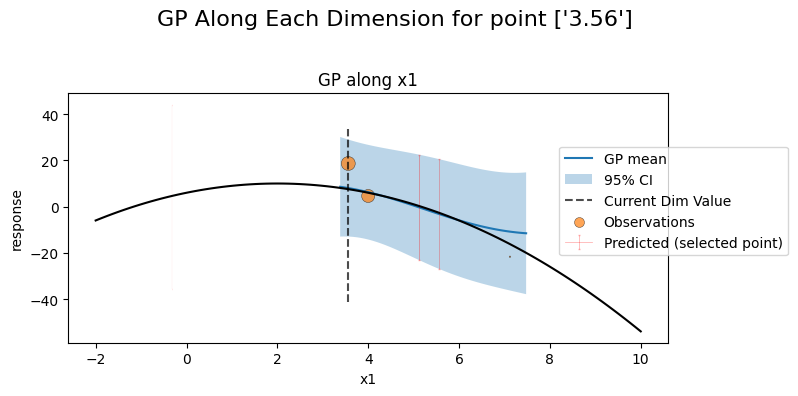

[INFO 09-22 11:57:43] ax.api.client: Trial 3 marked COMPLETED.
[INFO 09-22 11:57:43] ax.api.client: Trial 4 marked COMPLETED.
[INFO 09-22 11:57:43] ax.api.client: Trial 5 marked COMPLETED.
[INFO 09-22 11:57:44] ax.api.client: Generated new trial 6 with parameters {'x1': 3.281295} using GenerationNode GammaNoiseSGP+qLogExpectedImprovement.
[INFO 09-22 11:57:44] ax.api.client: Generated new trial 7 with parameters {'x1': 4.756954} using GenerationNode GammaNoiseSGP+qLogExpectedImprovement.
[INFO 09-22 11:57:44] ax.api.client: Generated new trial 8 with parameters {'x1': -1.092318} using GenerationNode GammaNoiseSGP+qLogExpectedImprovement.


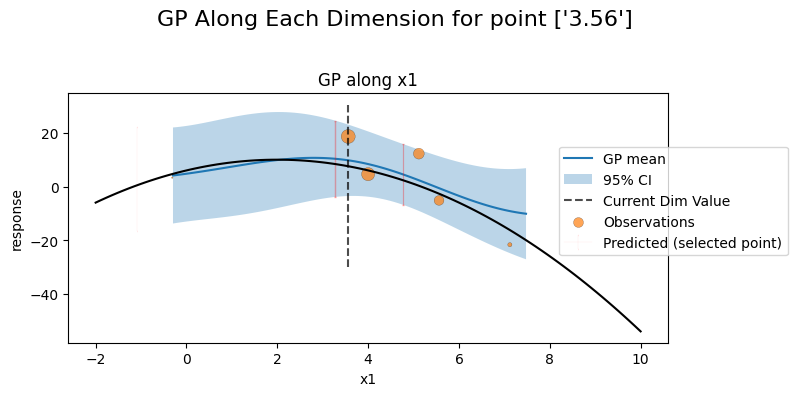

[INFO 09-22 11:57:45] ax.api.client: Trial 6 marked COMPLETED.
[INFO 09-22 11:57:45] ax.api.client: Trial 7 marked COMPLETED.
[INFO 09-22 11:57:45] ax.api.client: Trial 8 marked COMPLETED.
[INFO 09-22 11:57:46] ax.api.client: Generated new trial 9 with parameters {'x1': 2.102636} using GenerationNode GammaNoiseSGP+qLogExpectedImprovement.
[INFO 09-22 11:57:46] ax.api.client: Generated new trial 10 with parameters {'x1': 10.0} using GenerationNode GammaNoiseSGP+qLogExpectedImprovement.
[INFO 09-22 11:57:46] ax.api.client: Generated new trial 11 with parameters {'x1': 2.636331} using GenerationNode GammaNoiseSGP+qLogExpectedImprovement.


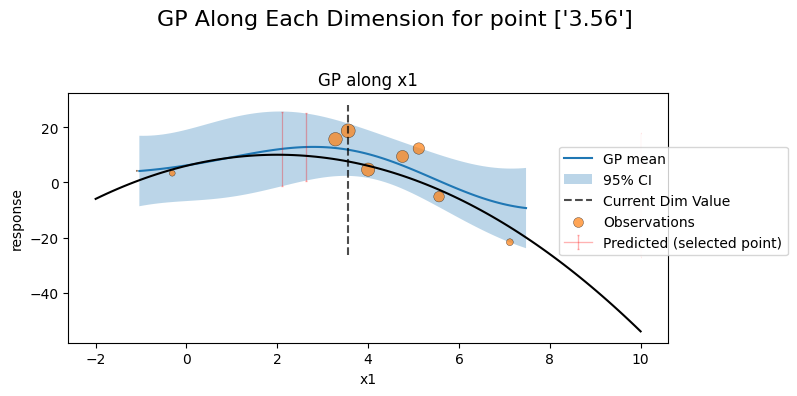

In [12]:
class GammaNoiseSGP(SingleTaskGP):
    """Just add a lot of assumed noise"""

    def __init__(
        self,
        train_X,
        train_Y,
        noise_concentration: float = 10,
        noise_rate: float = 10,
    ):

        likelihood = GaussianLikelihood(
            noise_prior=GammaPrior(noise_concentration, noise_rate)
        )

        super().__init__(
            train_X=train_X,
            train_Y=train_Y,
            likelihood=likelihood,
        )

runs = sequential_runs(GammaNoiseSGP, n_runs=3, technical_repeats=1, batch_size=3, noise_fn=noise_fn, plot_each=True)

* Introducing a noise channel significantly improves fit performance, even if no technical repeats are provided to narrow down the mean.
However,a heteroscedastic, or at least technical repeat aware noise kernel would be preferable.